# Extracting the cannonical protein and SNP data from Uniprot Proteome file

In [1]:
import pandas as pd
import json
#from jsonpath_ng import jsonpath, parse
import os
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from matplotlib import pyplot as plt
import math

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.getcwd()

'/content'

In [4]:
os.chdir('/content/drive/MyDrive/')

## Load JSON file containing all protein coding genes in the human proteome

In [5]:

# Load JSON data from file
with open('uniprotkb_AND_model_organism_9606_AND_r_2025_02_01.json','r', encoding='utf-8') as f:
    data = json.load(f)

# Define JSONPath expression
#jsonpath_expr = parse("results[*].features")

# Execute JSONPath expression
#array_test=[match.value for match in jsonpath_expr.find(data)]

# Extract primary accessions and associated natural variants
primary_accessions = []
natural_variants = {}



## Extract all primary accessions of the proteins, and their associated natural SNPS into Dictionary

In [6]:
proteomeDict={}
featureList=[]
variations_list=[]
proteomeDict_var={}

In [7]:
mylist=[]
for result in data.get("results", "."):
      PrimaryAccession=result.get("primaryAccession",[])
      mylist.append(PrimaryAccession)
      Features=result.get("features",".")
      if(Features!="."):
          for var in Features:
              if isinstance(var,dict):
                  variants= var.get("featureCrossReferences",".")
                  variation=var.get("featureId",".")
                  for SNP in variants:
                      if isinstance(SNP,dict):
                          varId= SNP.get("id",".")
                          if "rs" in varId:
                              featureList.append(varId)

                  if variants!="." and variation!="." and "VAR_" in variation:
                    variations_list.append(variation)


      proteomeDict[PrimaryAccession]=featureList
      featureList=[]
      proteomeDict_var[PrimaryAccession]=variations_list
      variations_list=[]



In [8]:
proteomeDict

{'A0A087X1C5': ['rs11090077', 'rs1800754', 'rs56127449', 'rs2070907'],
 'A0A0B4J2F0': [],
 'A0A0C5B5G6': [],
 'A0A0K2S4Q6': [],
 'A0A0U1RRE5': [],
 'A0A1B0GTW7': ['rs553352307', 'rs183023758', 'rs2140282332'],
 'A0AV02': ['rs2993631', 'rs863642', 'rs621383', 'rs6773138', 'rs2981482'],
 'A0AV96': ['rs35529250', 'rs278981'],
 'A0AVF1': ['rs1794039778', 'rs13225917', 'rs2130872867'],
 'A0AVI4': ['rs798752'],
 'A0AVK6': ['rs793274'],
 'A0AVT1': ['rs10010188'],
 'A0FGR8': ['rs13233513', 'rs2305473'],
 'A0FGR9': ['rs17857138', 'rs6772467', 'rs10935282', 'rs35537868'],
 'A0JLT2': [],
 'A0JNW5': ['rs58214704', 'rs7296162', 'rs17029945'],
 'A0JP26': ['rs200845208',
  'rs2605913',
  'rs2458862',
  'rs2445603',
  'rs1949282',
  'rs1828869',
  'rs1828868'],
 'A0M8Q6': [],
 'A0MZ66': [],
 'A0PJK1': ['rs12604020'],
 'A0PJY2': ['rs587777739'],
 'A0PK00': [],
 'A0PK11': ['rs13147559', 'rs2597791', 'rs1711990645'],
 'A1A4S6': ['rs17024215', 'rs2276932'],
 'A1A4Y4': ['rs180802994', 'rs72553867'],
 'A1A5

In [9]:
len(mylist)

20421

In [10]:
len(proteomeDict)

20421

In [11]:
Accession_num=[]
for key in proteomeDict:
    Accession_num.append(key)
len(Accession_num)

20421

## Get Protein sequence for every accession

In [12]:
import aiohttp
import asyncio
import re
#Accession_num=Accession_num[:10]
async def get_sequence(session, accession, semaphore):
    """Fetches the sequence from UniProt for a given accession number asynchronously."""
    url = f"https://www.uniprot.org/uniprot/{accession}.fasta"
    try:
        async with semaphore:  # Limit concurrent requests
            async with session.get(url, timeout=15) as response:
                if response.status != 200:
                    return "n/a"
                text = await response.text()
                sequence = re.sub(r'^.*\n', '', text).replace('\n', '')
                return sequence
    except Exception as e:
        print(f"Error fetching {accession}: {e}")
        return "n/a"

async def get_sequence_list(Accession_num):
    """Fetches sequences for multiple accession numbers with rate limiting."""
    semaphore = asyncio.Semaphore(10)  # Allow only 5 requests at a time
    async with aiohttp.ClientSession() as session:
        tasks = [get_sequence(session, accession, semaphore) for accession in Accession_num]
        return await asyncio.gather(*tasks)

# Running the async function in Jupyter
sequence_list = await get_sequence_list(Accession_num)

# Print results
for count, sequence in enumerate(sequence_list, start=1):
    print(count, sequence)


Streaming output truncated to the last 5000 lines.
15422 MCFLRRPGAPASWIWWRMLRQVLRRGLQSFCHRLGLCVSRHPVFFLTVPAVLTITFGLSALNRFQPEGDLERLVAPSHSLAKIERSLASSLFPLDQSKSQLYSDLHTPGRYGRVILLSPTGDNILLQAEGILQTHRAVLEMKDGRNSFIGHQLGGVVEVPNSKDQRVKSARAIQITYYLQTYGSATQDLIGEKWENEFCKLIRKLQEEHQELQLYSLASFSLWRDFHKTSILARSKVLVSLVLILTTATLSSSMKDCLRSKPFLGLLGVLTVCISIITAAGIFFITDGKYNSTLLGIPFFAMGHGTKGVFELLSGWRRTKENLPFKDRIADAYSDVMVTYTMTSSLYFITFGMGASPFTNIEAVKVFCQNMCVSILLNYFYIFSFFGSCLVFAGQLEQNRYHSIFCCKIPSAEYLDRKPVWFQTVMSDGHQQTSHHETNPYQHHFIQHFLREHYNEWITNIYVKPFVVILYLIYASFSFMGCLQISDGANIINLLASDSPSVSYAMVQQKYFSNYSPVIGFYVYEPLEYWNSSVQDDLRRLCSGFTAVSWVEQYYQFLKVSNVSANNKSDFISVLQSSFLKKPEFQHFRNDIIFSKAGDESNIIASRLYLVARTSRDKQKEITEVLEKLRPLSLSKSIRFIVFNPSFVFMDHYSLSVTVPVLIAGFGVLLVLILTFFLVIHPLGNFWLILSVTSIELGVLGLMTLWNVDMDCISILCLIYTLNFAIDHCAPLLFTFVLATEHTRTQCIKSSLQDHGTAILQNVTSFLIGLVPLLFVPSNLTFTLFKCLLLTGGCTLLHCFVILPVFLTFFPPSKKHHKKKKRAKRKEREEIECIEIQENPDHVTTV
15423 MEALEVDDISPALEVTEEFFSTLDSNLEKAVQQAEVYGIQEVPELVGHEVLSNITDNGAMRNVTSLGKGGMIWDHCKSRLLETKAQNVFP

In [17]:
len(sequence_list)

20421

In [18]:
sequence_list[0]

'MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNLLHVDFQNTPYCFDQLRRRFGDVFSLQLAWTPVVVLNGLAAVREAMVTRGEDTADRPPAPIYQVLGFGPRSQGVILSRYGPAWREQRRFSVSTLRNLGLGKKSLEQWVTEEAACLCAAFADQAGRPFRPNGLLDKAVSNVIASLTCGRRFEYDDPRFLRLLDLAQEGLKEESGFLREVLNAVPVLPHIPALAGKVLRFQKAFLTQLDELLTEHRMTWDPAQPPRDLTEAFLAKKEKAKGSPESSFNDENLRIVVGNLFLAGMVTTSTTLAWGLLLMILHLDVQRGRRVSPGCPIVGTHVCPVRVQQEIDDVIGQVRRPEMGDQAHMPCTTAVIHEVQHFGDIVPLGVTHMTSRDIEVQGFRIPKGTTLITNLSSVLKDEAVWKKPFRFHPEHFLDAQGHFVKPEAFLPFSAGRRACLGEPLARMELFLFFTSLLQHFSFSVAAGQPRPSHSRVVSFLVTPSPYELCAVPR'

##Histogram of Natural Non-Synonomous Variants

In [33]:
num_variations=[]
for key in proteomeDict:
    num_variations.append(len(proteomeDict.get(key)))

### Get descriptive statistics

In [34]:
df=pd.DataFrame(num_variations,columns=["natural non-synonomous variants"])
df.describe()

,natural non-synonomous variants
count,20421.000000
mean,3.408550
std,11.321438
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,536.000000


## Plot histogram

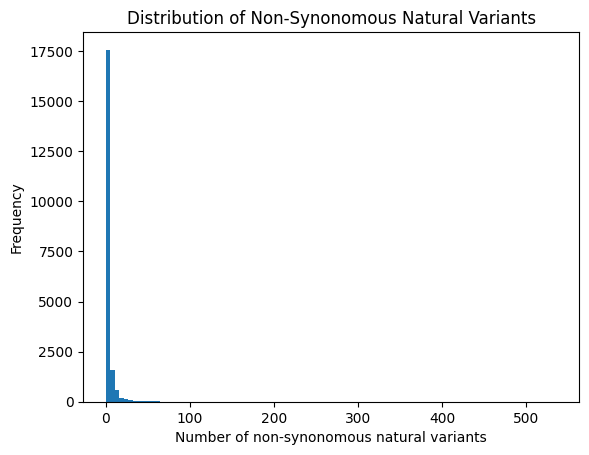

In [35]:
plt.hist(num_variations,bins=100)
plt.xlabel("Number of non-synonomous natural variants")
plt.ylabel("Frequency")
plt.title("Distribution of Non-Synonomous Natural Variants")
plt.show()

In [36]:
pd.DataFrame(df["natural non-synonomous variants"].value_counts())

,count
natural non-synonomous variants,
0,7669
1,3909
2,2529
3,1632
4,1073
...,...
192,1
84,1
106,1


In [37]:
np.mean(np.array([num_variations]))

3.408550022036139

## Extract HGVS protein nomenclature from RsID

In [38]:
aminoChanges=[]

In [43]:
import aiohttp
import asyncio
import re
from bs4 import BeautifulSoup
# Each call to get_aminoSubstitution will create its own session
async def get_aminoSubstitution(variant_id):
    url = f"https://web.expasy.org/variant_pages/{variant_id}.html"
    try:
        async with aiohttp.ClientSession() as session:  # Session created here
            async with session.get(url, timeout=10) as response:
                if response.status != 200:
                    return -5  # Error code (e.g., timeout or bad response)
                html = await response.text()
                soup = BeautifulSoup(html, 'html.parser')
                variant_description_find = soup.find('h1')
                if variant_description_find is None:
                    return -1  # Error code (variant not found)
                variant_description = soup.find('h1').text.strip()
                match = re.search(r'\bp.\w+', variant_description)
                return match.group() if match else -1
    except Exception as e:
        print(f"Error with variant {variant_id}: {e}")
        return -5  # Network error or request failure

In [44]:
async def get_aminoSubstitution_list(variant_list):
    var_list = []
    tasks = [get_aminoSubstitution(var) for var in variant_list]
    results = await asyncio.gather(*tasks)

    for ret_val in results:
        if ret_val == -1 or ret_val == -5:
            var_list.append("n/a")
        else:
            var_list.append(ret_val)

    return var_list

In [48]:
# Processing proteomeDict_var asynchronously
snp_list = []
count = 0
for key, var_list in proteomeDict_var.items():
  item = await get_aminoSubstitution_list(var_list)
  print(item, count)
  count += 1
  snp_list.append(item)

Streaming output truncated to the last 5000 lines.
[] 15421
[] 15422
['p.Gly47Glu', 'p.Lys459Glu', 'p.Asp688Val', 'p.Pro1193Arg'] 15423
['p.Ala4Thr', 'p.Asp124Asn'] 15424
[] 15425
['p.Asn208Lys', 'p.Arg320Leu', 'p.Asp461Ala', 'p.Val522Gly', 'p.His666Gln', 'p.Phe698Ser', 'p.Asp741Gly', 'p.Asp883Asn', 'p.Phe958Tyr', 'p.Gly1084Ala', 'p.Val1254Ile', 'p.Gly1337Ser'] 15426
[] 15427
['p.Gly56Ser'] 15428
[] 15429
['p.Ala67Val', 'p.Gly88Val'] 15430
[] 15431
[] 15432
['p.Arg346Lys'] 15433
['p.Asp207Asn'] 15434
['p.Arg28Ser', 'p.Ile80Thr', 'p.Val95Ile', 'p.Arg202Gly', 'p.Glu203Lys', 'p.Asn235Ser', 'p.Ser279Leu', 'p.Pro364Arg'] 15435
[] 15436
['p.Gly41Glu', 'p.Pro236Arg'] 15437
['p.Ser343Asn', 'p.Ala358Ser', 'p.Pro416Ser'] 15438
[] 15439
[] 15440
['p.Tyr175Phe', 'p.Phe196Ser', 'p.Trp255Gly', 'p.Cys265Tyr', 'p.Gln292Arg', 'p.Pro311Ala'] 15441
['p.Ala392Val', 'p.Gly465Trp'] 15442
['p.Leu1640Phe'] 15443
['p.Val55Ile'] 15444
[] 15445
['p.Cys53Tyr', 'p.Leu118Ser', 'p.Arg290Cys'] 15446
['p.Arg133Cys', '

In [49]:
snp_list

[['p.Ser70Asn', 'p.Ser311Leu', 'p.His383Arg', 'p.Lys428Glu'],
 [],
 [],
 [],
 [],
 ['p.Ser31Phe', 'p.Ser384Leu', 'p.Arg389Ile'],
 ['p.Arg181Cys', 'p.Leu266Pro', 'p.Ile281Val', 'p.Lys541Arg', 'p.Arg664Gln'],
 ['p.Gly538Arg', 'p.Met565Val'],
 ['p.Asn263Ser', 'p.Asp310Asn', 'p.Pro444Leu'],
 ['p.Leu83Ile'],
 ['p.Ile674Val'],
 ['p.Ala224Thr'],
 ['p.Cys210Ser', 'p.Ser638Gly'],
 ['p.Pro246Gln', 'p.Gly416Arg', 'p.Gly590Arg', 'p.Thr662Ser'],
 [],
 ['p.Met1111Leu', 'p.Ser1147Leu', 'p.Ile1175Val'],
 ['p.His30Asp',
  'p.Met43Val',
  'p.Asn88Asp',
  'p.Gln286Glu',
  'p.Lys511Glu',
  'p.Met535Lys',
  'p.Ala568Thr'],
 [],
 [],
 ['p.Ala522Val'],
 ['p.His278Tyr'],
 [],
 ['p.Leu113Val', 'p.Ala153Thr', 'p.Thr165Lys'],
 ['p.Pro488Ser', 'p.Met684Val'],
 ['p.Glu17Asp', 'p.Thr94Lys'],
 ['p.Pro173Ser'],
 ['p.Leu93Phe', 'p.Ile391Val', 'p.Cys399Arg'],
 [],
 ['p.Ile222Thr'],
 [],
 ['p.Ile343Thr',
  'p.Arg583Gln',
  'p.Asp616Ala',
  'p.Met981Val',
  'p.Val1327Asp',
  'p.Arg1399Lys',
  'p.Asp1452Glu'],
 ['p.Asn374

### Preprocessing and Saving dataset

In [50]:
proteomeDict_var

{'A0A087X1C5': ['VAR_072632', 'VAR_072633', 'VAR_072636', 'VAR_072637'],
 'A0A0B4J2F0': [],
 'A0A0C5B5G6': [],
 'A0A0K2S4Q6': [],
 'A0A0U1RRE5': [],
 'A0A1B0GTW7': ['VAR_086199', 'VAR_086203', 'VAR_086204'],
 'A0AV02': ['VAR_035199',
  'VAR_035200',
  'VAR_062148',
  'VAR_035201',
  'VAR_035202'],
 'A0AV96': ['VAR_061832', 'VAR_054770'],
 'A0AVF1': ['VAR_086383', 'VAR_032568', 'VAR_086384'],
 'A0AVI4': ['VAR_032803'],
 'A0AVK6': ['VAR_034735'],
 'A0AVT1': ['VAR_030594'],
 'A0FGR8': ['VAR_030725', 'VAR_030726'],
 'A0FGR9': ['VAR_038117', 'VAR_038118', 'VAR_053835', 'VAR_062173'],
 'A0JLT2': [],
 'A0JNW5': ['VAR_061719', 'VAR_051467', 'VAR_051468'],
 'A0JP26': ['VAR_080181',
  'VAR_019915',
  'VAR_019919',
  'VAR_080183',
  'VAR_019921',
  'VAR_019922',
  'VAR_059119'],
 'A0M8Q6': [],
 'A0MZ66': [],
 'A0PJK1': ['VAR_052493'],
 'A0PJY2': ['VAR_071918'],
 'A0PK00': [],
 'A0PK11': ['VAR_053826', 'VAR_053827', 'VAR_085237'],
 'A1A4S6': ['VAR_049141', 'VAR_035114'],
 'A1A4Y4': ['VAR_039899', 

In [51]:
Protein_accession_num=pd.DataFrame({"Acession_num":Accession_num});

In [52]:
protein_dataset=pd.DataFrame({"Acession_num":Accession_num,"Cannonical_sequences":sequence_list,"SNPS":snp_list})

In [53]:
protein_dataset["SNPS"]=protein_dataset["SNPS"].apply(lambda x: "NULL" if len(x)==0 else x)

In [54]:
protein_dataset.isnull().sum()

,0
Acession_num,0
Cannonical_sequences,0
SNPS,0


In [56]:
protein_dataset["Cannonical_sequences"]=protein_dataset["Cannonical_sequences"].apply(lambda x: None if x=='' else x)

In [57]:
protein_dataset.to_csv('Uniprot_protein_dataset_2025.csv', index=False)